## 1. Setup

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
#from fastai.vision.all import *
#from fastai.data.transforms import *

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/MyDrive/LiTS")
!ls

'Copy of Copie de Copy of LiTS final.ipynb'   imgs	   LiTS_png-pt2
'Copy of LiTS.ipynb'			      LiTS.ipynb   msks
 df_files.csv				      LiTS_png	   U-Net.pth


In [ ]:
# #import the data frame of the images
# df_files_png = pd.read_csv('df_files.csv', index_col = 0)
# df_files_png=df_files_png.sort_values(by=["mask_dirname_png","filename_png"],ascending=[True,True],ignore_index=True)
# df_files_png

In [5]:

# Création du dataframe contenant les images originales
file_list = []
for dirname, _, filenames in os.walk('imgs'):
    for filename in filenames:
        file_list.append(("imgs",filename,"msks",filename)) 



df_files = pd.DataFrame(file_list, columns =['dirname', 'filename','mask_dirname','mask_filename']) 
df_files.sort_values(by=['filename'], ascending=True)
num=len(df_files)  
df_files

,dirname,filename,mask_dirname,mask_filename
0,imgs,0.jpg,msks,0.jpg
1,imgs,1.jpg,msks,1.jpg
2,imgs,2.jpg,msks,2.jpg
3,imgs,3.jpg,msks,3.jpg
4,imgs,4.jpg,msks,4.jpg
...,...,...,...,...
568,imgs,568.jpg,msks,568.jpg
569,imgs,569.jpg,msks,569.jpg
570,imgs,570.jpg,msks,570.jpg
571,imgs,571.jpg,msks,571.jpg


In [6]:
#data frame of training set. for example,
train_number=3
train_set=df_files.iloc[[random.randint(0,num)]]
for i in range(train_number-1):
  entry = df_files.iloc[[random.randint(0,num)]]
  train_set=train_set.append(entry)
train_set=train_set.sort_values(by=["mask_dirname","filename"],ascending=[True,True])
indexes=[i for i in range(train_number)]
train_set["index"]=indexes
train_set

,dirname,filename,mask_dirname,mask_filename,index
154,imgs,154.jpg,msks,154.jpg,0
296,imgs,296.jpg,msks,296.jpg,1
308,imgs,308.jpg,msks,308.jpg,2


In [7]:
#data frame of test set. for example,
test_number=3
test_set=df_files.iloc[[random.randint(0,num)]]
for i in range(test_number-1):
  entry = df_files.iloc[[random.randint(0,num)]]
  test_set=test_set.append(entry)
test_set=test_set.sort_values(by=["mask_dirname","filename"],ascending=[True,True])
indexes=[i for i in range(test_number)]
test_set["index"]=indexes
test_set

,dirname,filename,mask_dirname,mask_filename,index
252,imgs,252.jpg,msks,252.jpg,0
342,imgs,342.jpg,msks,342.jpg,1
411,imgs,411.jpg,msks,411.jpg,2


In [8]:
#data frame of val set
val_number=3
val_set=df_files.loc[[random.randint(0,num)]]
for i in range(val_number-1):
  entry = df_files.loc[[random.randint(0,num)]]
  val_set=val_set.append(entry)
val_set=val_set.sort_values(by=["mask_dirname","filename"],ascending=[True,True])
indexes=[i for i in range(val_number)]
val_set["index"]=indexes
val_set


,dirname,filename,mask_dirname,mask_filename,index
137,imgs,137.jpg,msks,137.jpg,0
14,imgs,14.jpg,msks,14.jpg,1
67,imgs,67.jpg,msks,67.jpg,2


In [9]:
data_dir = os.path.join("./")
print(data_dir)


./


In [10]:
def openImage(k): #573
  vol=os.path.join("imgs/"+str(k)+".jpg")
  volume=Image.open(vol).convert("RGB")
  msk=os.path.join("msks/"+str(k)+".png")
  mask=Image.open(msk).convert("RGB")
  return volume,mask

## 2. Analyze data

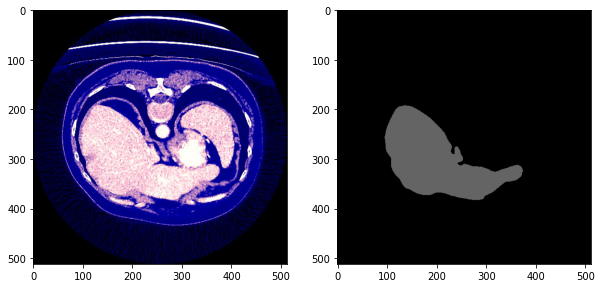

In [11]:
sample=54
volume, label = openImage(sample)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(volume)
lbl=np.asarray(label)*100
axes[1].imshow(lbl)
#axes[1].imshow(label)


## 3. Define Labels

In [12]:
# define labels 


num_items = 3
#rgb(112,123,143)
color_array = np.array([[0,0,0],[1,1,1],[2,2,2]])
print(color_array.shape)
print(color_array[:5, :])

(3, 3)
[[0 0 0]
 [1 1 1]
 [2 2 2]]


In [13]:
num_classes = 3
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(n_clusters=3)

In [14]:
label_model.predict(color_array[:5, :])
m=label_model.predict(color_array[:5, :])

In [15]:
volume, label = openImage(sample)

label_class = label_model.predict(np.array(label).reshape(-1, 3)).reshape(512, 512)
#fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#axes[0].imshow(volume)
#axes[1].imshow(lbl)
#lbl=np.asarray(label)*100
#axes[1].imshow(lbl)
#axes[2].imshow(label_class,cmap=plt.cm.bone)

In [16]:
label_class

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=int32)

## 4. Define Dataset

In [17]:
class LiverTumor(Dataset):
    
    def __init__(self, image_dataframe, label_model):
        self.image_dataframe = image_dataframe
        # self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_dataframe)
    
    def __getitem__(self, index):
        # image_fn = self.image_fns[index]
        # image_fp = os.path.join(self.image_dir, image_fn)
        # image = Image.open(image_fp).convert('RGB')
        # image = np.array(image)
        # volume, label = self.openImage(image)
        # label_class = self.label_model.predict(np.array(label.resize((256,256))).reshape(-1, 3)).reshape(256, 256)
        # volume = self.transform(volume)
        # label_class = torch.Tensor(label_class).long()
        # return volume, label_class

        k=self.image_dataframe.index[self.image_dataframe["index"]==index].tolist()[0]
        volume,label=self.openImage(k)
        label_class = self.label_model.predict(np.array(label).reshape(-1, 3)).reshape(512, 512)
        volume = self.transform(volume)
        label_class = torch.Tensor(label_class).long()
        return volume, label_class

    
    def openImage(self, k):
        vol=os.path.join("imgs/"+str(k)+".jpg")
        volume=Image.open(vol).convert("RGB")
        msk=os.path.join("msks/"+str(k)+".png")
        mask=Image.open(msk).convert("RGB")
        return volume,mask
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [18]:
dataset = LiverTumor(train_set, label_model)
print(len(dataset))

3


In [19]:
volume, label_class = dataset[0]
print(volume.shape, label_class.shape)

torch.Size([3, 512, 512]) torch.Size([512, 512])


## 5. Define Model

In [20]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [ 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [ 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [ 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [ 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [ 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [ 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [ 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [ 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [ 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [ 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [ 1024, 32, 32] -> [ 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [ 512, 64, 64] -> [ 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [ 256, 128, 128] -> [ 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [ 128, 256, 256] -> [ 64, 256, 256]
        output_out = self.output(expansive_42_out) # [ num_classes, 256, 256]
        return output_out

In [21]:
model = UNet(num_classes=num_classes)

In [22]:
torch.set_printoptions(profile="default")

In [23]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)


3 1
torch.Size([3, 3, 512, 512]) torch.Size([3, 512, 512])


In [24]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([3, 3, 512, 512])


## 6. Train the model

In [25]:
batch_size = 8

epochs = 12
lr = 0.01

In [26]:
dataset = LiverTumor(train_set, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [27]:
model = UNet(num_classes=num_classes).to(device)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
datasettest = LiverTumor(test_set, label_model)
data_loader_test = DataLoader(datasettest, batch_size=batch_size)
epoch_losses_test = []
step_losses_test = []

for epoch in tqdm(range(epochs)):
    epoch_loss_test = 0
    for X, Y in tqdm(data_loader_test, total=len(data_loader_test), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss_test += loss.item()
        step_losses_test.append(loss.item())
    epoch_losses_test.append(epoch_loss_test/len(data_loader_test))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, "Erreur de test en fonction de l'epoch")

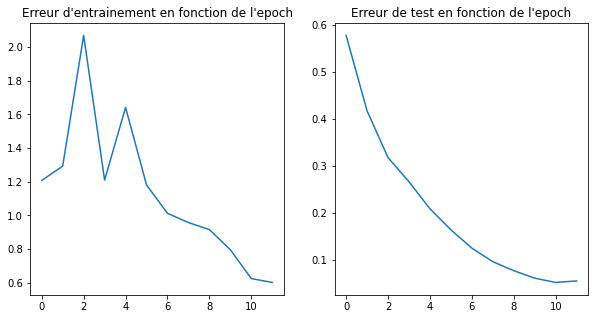

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(epoch_losses) #erreur entrainement
axes[1].plot(epoch_losses_test) #erreur test
axes[0].set_title("Erreur d'entrainement en fonction de l'epoch")
axes[1].set_title("Erreur de test en fonction de l'epoch")

In [32]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

## 7. Check model predictions

In [33]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [34]:
test_batch_size = val_number - 1
dataset = LiverTumor(val_set, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [35]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)


torch.Size([2, 3, 512, 512])
torch.Size([2, 512, 512])


In [36]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

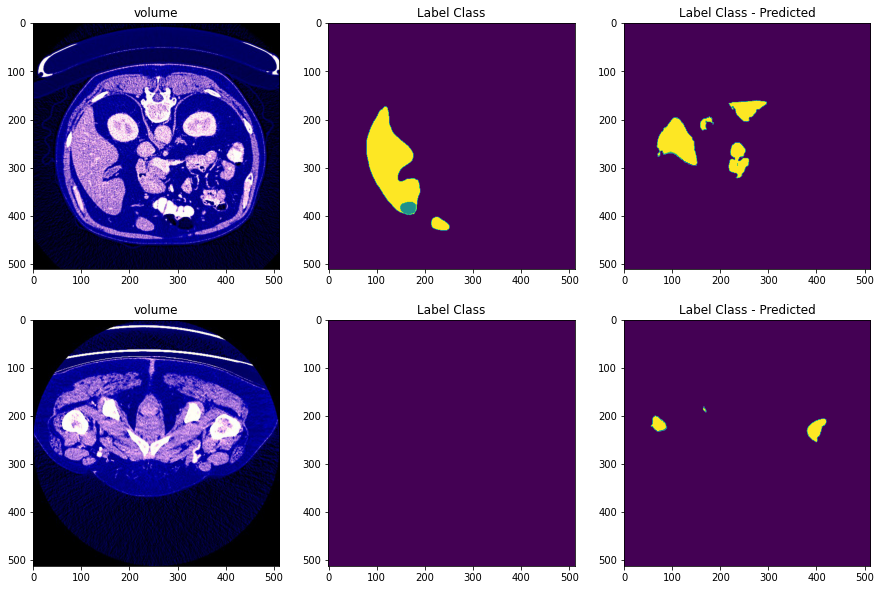

In [37]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    volume = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    #Y = Y.long()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    # label_class_predicted = label_class_predicted.swapaxes(0,1)
    # label_class_predicted = label_class_predicted.swapaxes(1,2)
    axes[i, 0].imshow(volume)
    axes[i, 0].set_title("volume")
    lbl=np.asarray(label_class)*100
    axes[i, 1].imshow(lbl)
    #axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")